In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
result_dir = "/media/justus/Data/OneDrive/Dokumente/Studium/Master/Master Thesis/Results"
all_experiments = ["default", "noise", "size", "time"]
spiking_models = ["SAE", "SAE_sparse", "SAE_dense"]

In [3]:
def load_results(experiments):
    results = pd.DataFrame([])

    for e in experiments:
        path = Path(result_dir, f"results_{e}.csv")
        df = pd.read_csv(path)
        df["experiment"] = e
        results = pd.concat([results, df])
    
    return results

In [4]:
results_noise = load_results(["default", "noise"])
results_size = load_results(["default", "size"])
results_time = load_results(["default", "time"])

In [5]:
#for c in results.columns:
#    print(c)

In [6]:
variables = ["validation neuron activity correlation",
             "validation example activity correlation",
             "validation mean activity",
             "validation latent pct active",
             "validation latent pct active per example",
             "validation loss",
             "validation reconstruction loss",
             "validation L1 weight loss",
             "validation L2 weight loss",
             "validation example activity loss 2",
             "validation neuron activity loss 2",
             "validation mean pixelwise error",
             "validation own mse",
             "validation spike density"
             ]


In [7]:
def plot_variables_over_time(df, variables, models=[], hue=None, style=None, ci=68, xlog=False, ylog=False):
    
    for y in variables:
        f, ax = plt.subplots(figsize=(7, 7))
        if xlog:
            ax.set(xscale="log")
        if ylog:
            ax.set(yscale="log")
        df = df[df["model"].isin(models)]
        df = df[df["epoch"]>0]
        sns.lineplot(data=df.loc[df["epoch"]>0],
                     x="epoch",
                     y=y,
                     style=style,
                     hue=hue,
                     legend="full",
                     hue_norm=mpl.colors.LogNorm(),
                     #dashes=False,
                     ci=ci,
                     )
        plt.show()

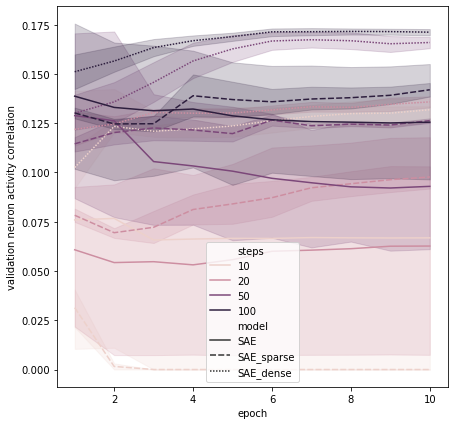

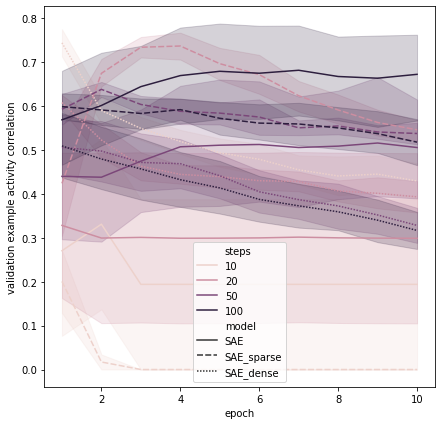

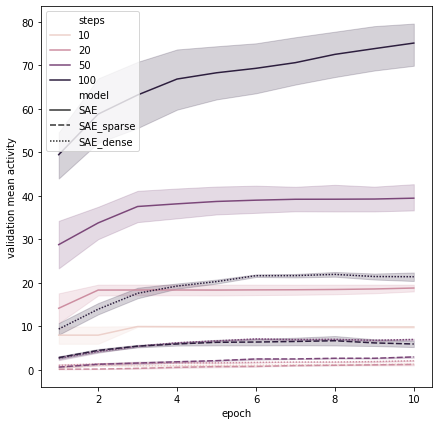

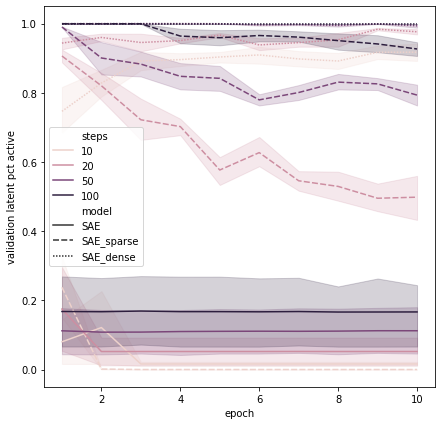

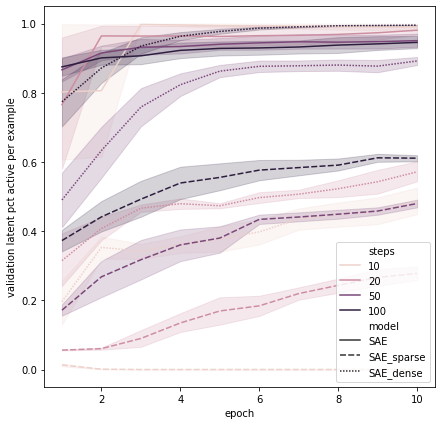

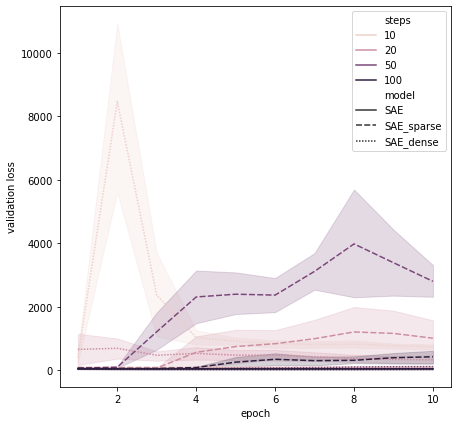

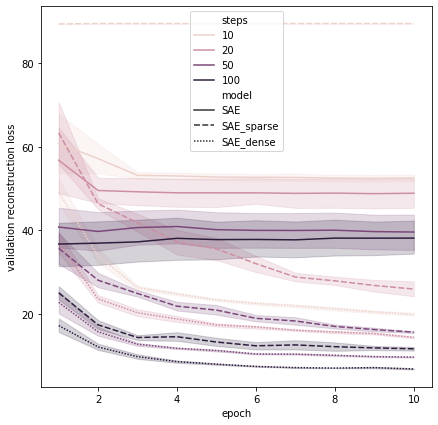

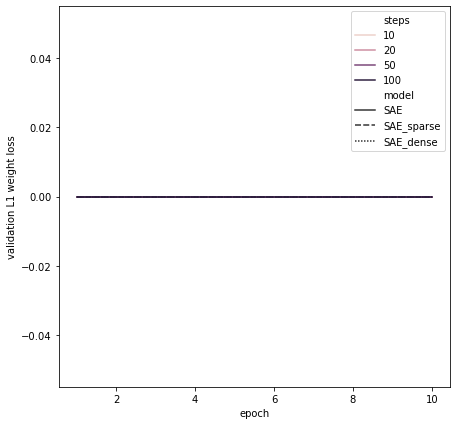

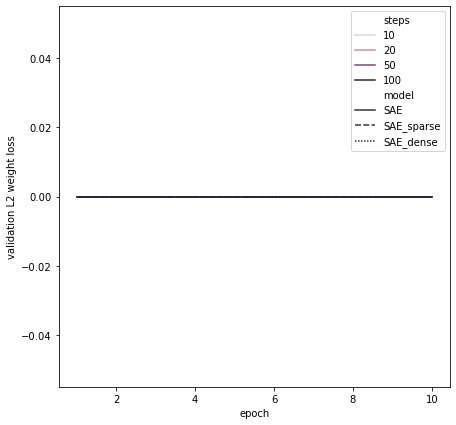

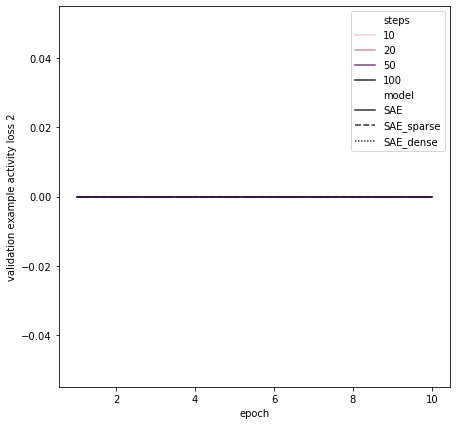

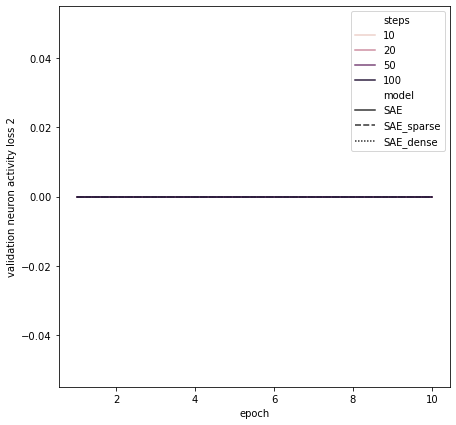

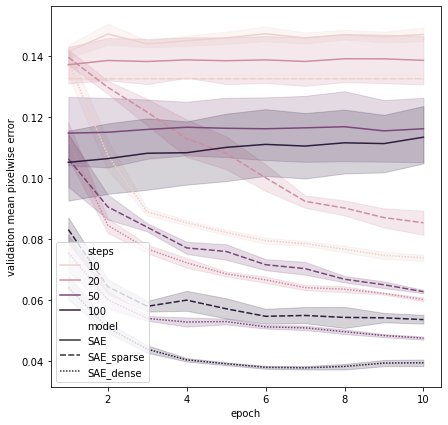

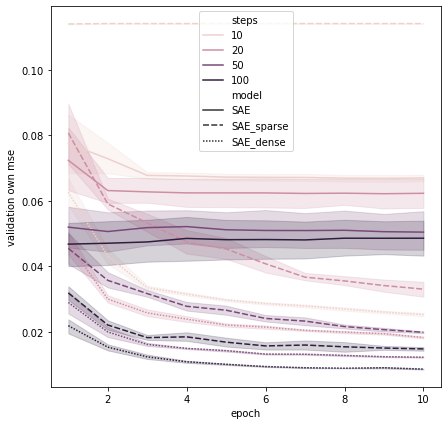

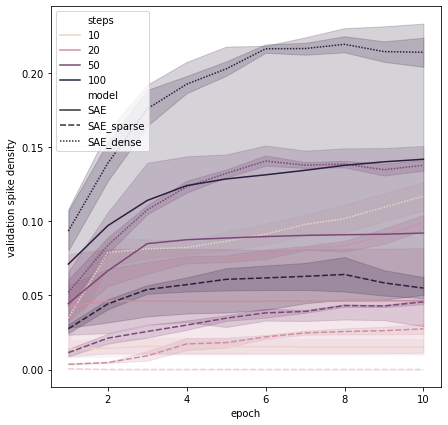

In [8]:
plot_variables_over_time(results_time, variables, spiking_models, "steps", "model")


In [9]:
def plot_variables_in_boxplot(df, variables, models, x, hue=None, epoch=10, xlog=False, ylog=False):
    
    for y in variables:
        f, ax = plt.subplots(figsize=(7, 7))
        if xlog:
            ax.set(xscale="log")
        if ylog:
            ax.set(yscale="log")
        df = df[df["model"].isin(models)]
        df = df[df["epoch"]==epoch]
        sns.boxplot(data=df,
                    x=x,
                    y=y,
                    hue=hue,
                    )
        plt.show()

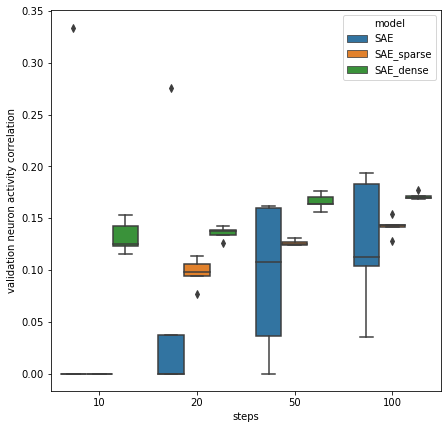

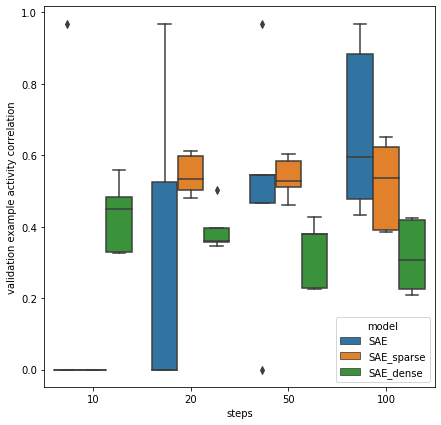

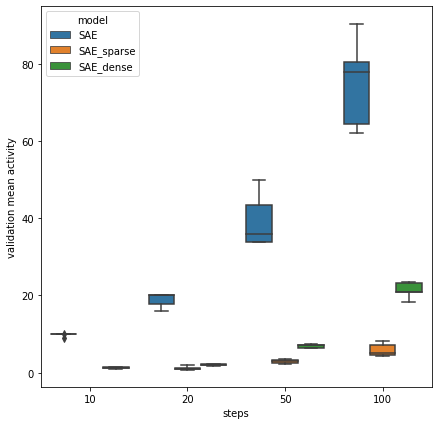

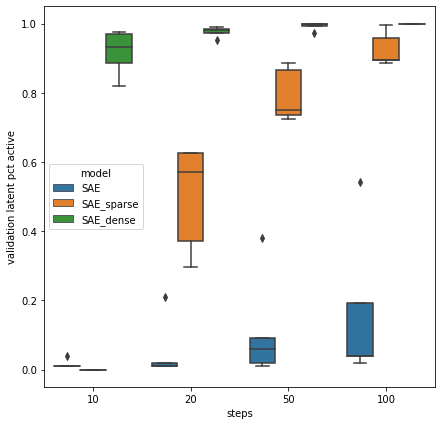

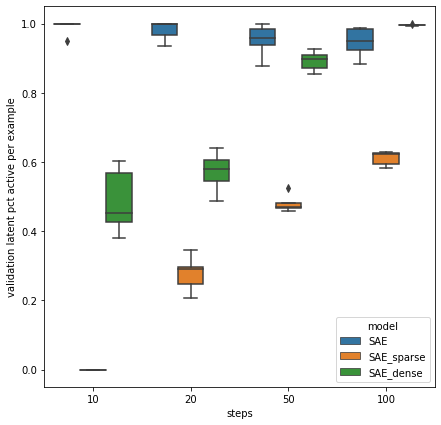

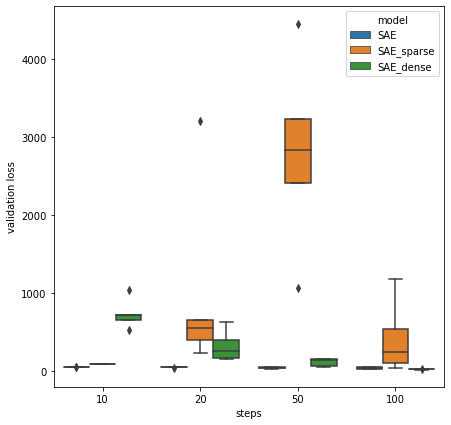

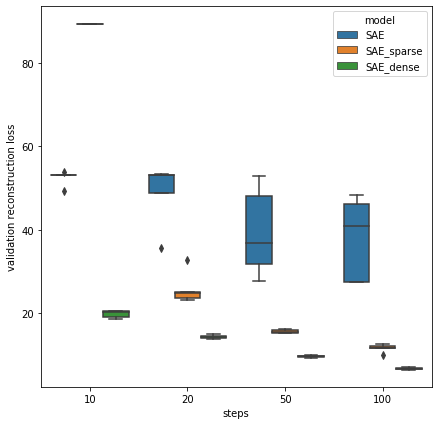

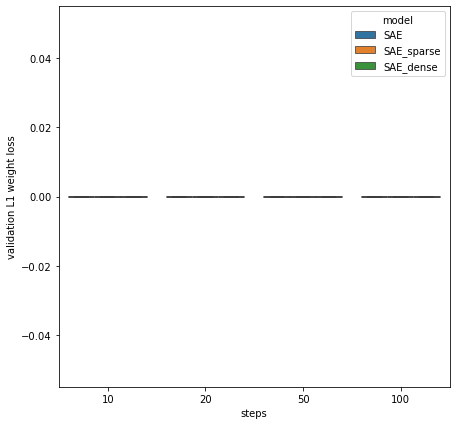

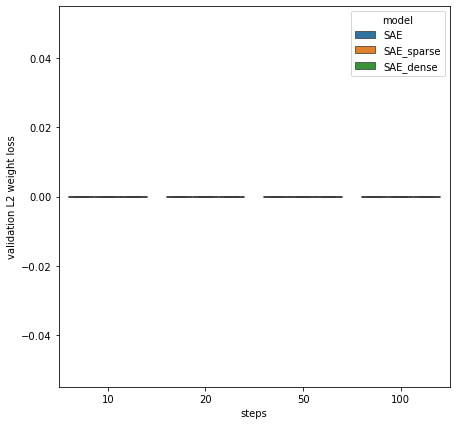

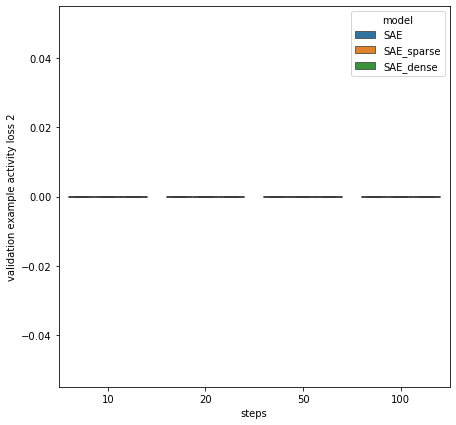

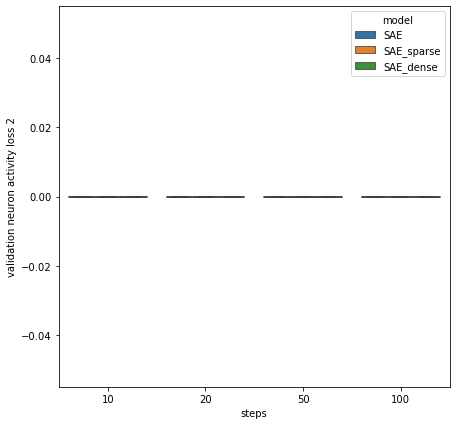

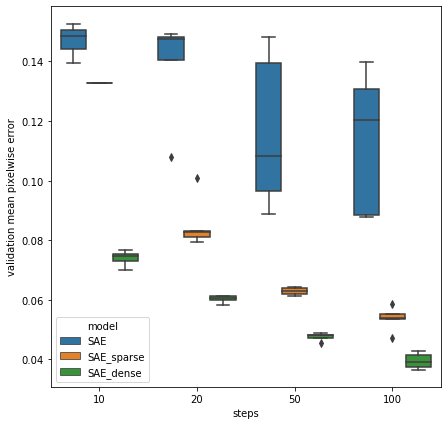

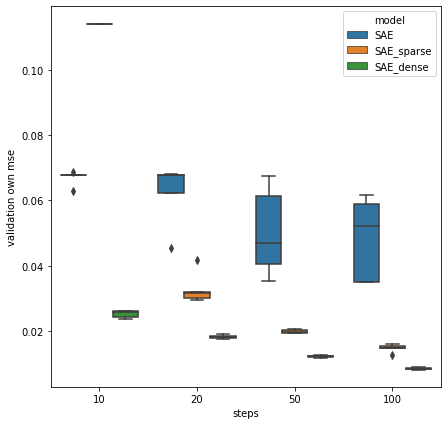

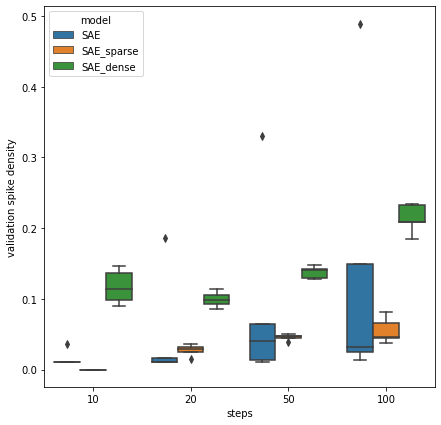

In [10]:
plot_variables_in_boxplot(results_time, variables, spiking_models, "steps", "model")